In [ ]:
!kaggle datasets download -d nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone

Dataset URL: https://www.kaggle.com/datasets/nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone
License(s): copyright-authors
100% 1.52G/1.52G [01:09<00:00, 31.3MB/s]
100% 1.52G/1.52G [01:09<00:00, 23.4MB/s]


In [ ]:
!unzip -q /content/ct-kidney-dataset-normal-cyst-tumor-and-stone.zip -d /content/

In [ ]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [ ]:
data_path = "/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"
# /kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"
images = []
labels = []

for subfolder in os.listdir(data_path):

    subfolder_path = os.path.join(data_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue

    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)

        labels.append(subfolder)

data = pd.DataFrame({'image': images, 'label': labels})

In [ ]:
data.head(100)

,image,label
0,/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...,Normal
1,/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...,Normal
2,/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...,Normal
3,/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...,Normal
4,/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...,Normal
...,...,...
95,/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...,Normal
96,/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...,Normal
97,/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...,Normal
98,/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...,Normal


In [ ]:
data.shape

(12446, 2)

In [ ]:
strat = data['label']
train_df, dummy_df = train_test_split(data,  train_size= 0.80, shuffle= True, random_state= 123, stratify= strat)

strat = dummy_df['label']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

In [ ]:
print("Training set shape:", train_df.shape)
print("Validation set shape:", valid_df.shape)
print("Test set shape:", test_df.shape)

Training set shape: (9956, 2)
Validation set shape: (1245, 2)
Test set shape: (1245, 2)


In [ ]:
batch_size = 32
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='image', y_col='label', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='image', y_col='label', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='image', y_col='label', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 9956 validated image filenames belonging to 4 classes.
Found 1245 validated image filenames belonging to 4 classes.
Found 1245 validated image filenames belonging to 4 classes.


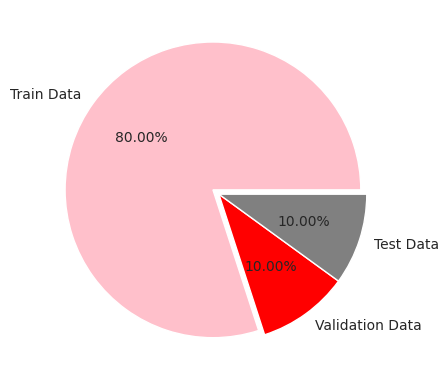

In [ ]:
plt.pie([len(train_gen), len(valid_gen), len(test_gen)],
        labels=['Train Data', 'Validation Data', 'Test Data'], autopct='%.2f%%', colors=['pink', 'red', 'grey'], explode=(0.05, 0, 0))
plt.show()

In [ ]:
print(train_gen.class_indices)
print(test_gen.class_indices)
print(valid_gen.class_indices)

{'Cyst': 0, 'Normal': 1, 'Stone': 2, 'Tumor': 3}
{'Cyst': 0, 'Normal': 1, 'Stone': 2, 'Tumor': 3}
{'Cyst': 0, 'Normal': 1, 'Stone': 2, 'Tumor': 3}


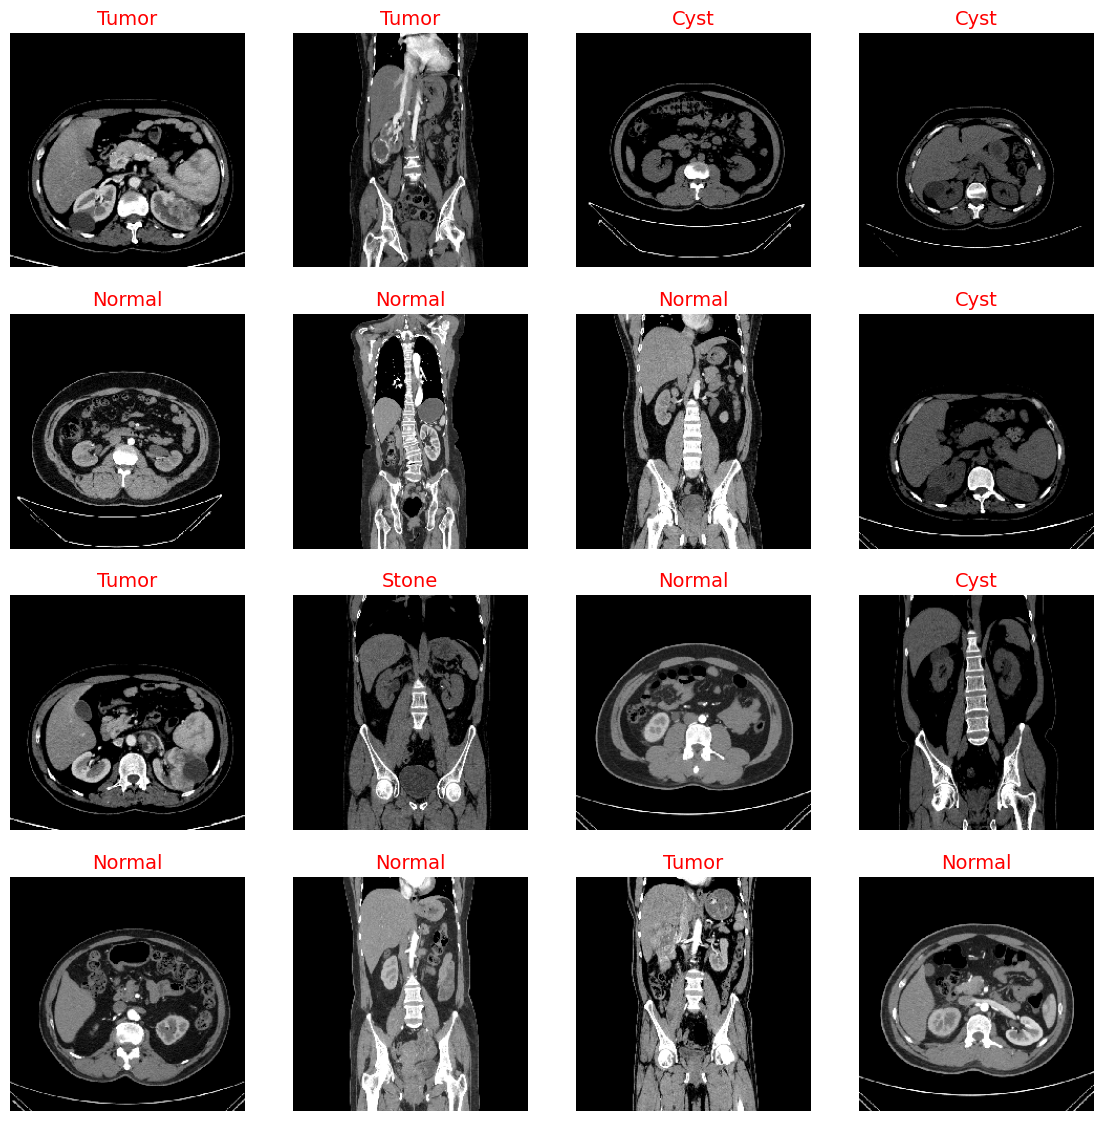

In [ ]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize= (14, 14))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color= 'Red', fontsize= 14)
    plt.axis('off')
plt.show()

# **Creating a CNN-Model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

In [ ]:
n_classes = 4
input_shape = (224, 224, 3)

model = Sequential()

# Block 1
model.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(2))
model.add(Dropout(0.25))

# Block 2
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2))
model.add(Dropout(0.35))

# Block 3
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2))
model.add(Dropout(0.45))

# Block 4
model.add(Conv2D(256, (3,3), activation='relu'))
model.add(Conv2D(256, (3,3), activation='relu'))
model.add(MaxPooling2D(2))
model.add(Dropout(0.5))

# Fully connected layers
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 220, 220, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 110, 110, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 110, 110, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 108, 108, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 106, 106, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 53, 53, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 53, 53, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 51, 51, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 49, 49, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 22, 22, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 20, 20, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,276,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,457,700 (17.00 MB)

 Trainable params: 4,457,700 (17.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Epoch 1/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 97s 232ms/step - accuracy: 0.3301 - loss: 6.5453 - val_accuracy: 0.4530 - val_loss: 4.2594
Epoch 2/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 105s 173ms/step - accuracy: 0.4420 - loss: 4.1365 - val_accuracy: 0.5767 - val_loss: 3.7489
Epoch 3/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 82s 175ms/step - accuracy: 0.5333 - loss: 3.6180 - val_accuracy: 0.5847 - val_loss: 3.3092
Epoch 4/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 54s 172ms/step - accuracy: 0.5983 - loss: 3.1532 - val_accuracy: 0.6659 - val_loss: 2.8518
Epoch 5/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 83s 175ms/step - accuracy: 0.6232 - loss: 2.7819 - val_accuracy: 0.6859 - val_loss: 2.4250
Epoch 6/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 81s 172ms/step - accuracy: 0.6656 - loss: 2.3855 - val_accuracy: 0.7904 - val_loss: 2.0271
Epoch 7/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 55s 175ms/step - accuracy: 0.6991 - loss: 2.0827 - val_accuracy: 0.8546 - val_loss: 1.6579
Epoch 8/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 54s 171ms/step - accuracy: 0.7377 - loss: 

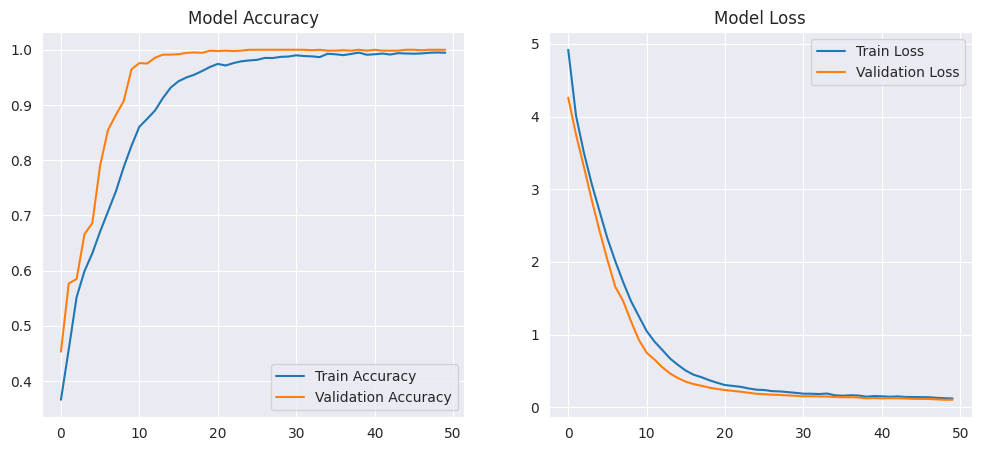

In [ ]:
history = model.fit(train_gen, epochs=50, validation_data=valid_gen)

# Plot accuracy and loss curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import classification_report

y_pred = np.argmax(model.predict(test_gen), axis=-1)
y_true = test_gen.classes

print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))

39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 234ms/step
              precision    recall  f1-score   support

        Cyst       1.00      1.00      1.00       371
      Normal       1.00      1.00      1.00       508
       Stone       1.00      1.00      1.00       138
       Tumor       1.00      1.00      1.00       228

    accuracy                           1.00      1245
   macro avg       1.00      1.00      1.00      1245
weighted avg       1.00      1.00      1.00      1245



In [ ]:
model.save('CNN_Model.keras')

# **Using ResNet50 Model**

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [ ]:
# Load the pre-trained ResNet50 model without the top classification layer
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers to prevent them from being trained
resnet50_base.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Add custom classification layers on top of the ResNet50 base
x = resnet50_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(n_classes, activation='softmax')(x)

In [ ]:
# Create the final model
resnet50_model = Model(inputs=resnet50_base.input, outputs=outputs)

In [ ]:
# Compile the model
resnet50_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
resnet50_model.summary()

Model: "functional_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,850,500 (90.98 MB)

 Trainable params: 262,788 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 119s 331ms/step - accuracy: 0.5331 - loss: 1.2705 - val_accuracy: 0.8217 - val_loss: 0.4964
Epoch 2/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 87s 275ms/step - accuracy: 0.8010 - loss: 0.5355 - val_accuracy: 0.9052 - val_loss: 0.3047
Epoch 3/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 132s 241ms/step - accuracy: 0.8832 - loss: 0.3461 - val_accuracy: 0.9454 - val_loss: 0.2161
Epoch 4/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.9182 - loss: 0.2562Epoch 5/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 83s 231ms/step - accuracy: 0.9317 - loss: 0.2155 - val_accuracy: 0.9735 - val_loss: 0.1261
Epoch 6/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 85s 242ms/step - accuracy: 0.9518 - loss: 0.1744 - val_accuracy: 0.9743 - val_loss: 0.1059
Epoch 7/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 74s 234ms/step - accuracy: 0.9614 - loss: 0.1396 - val_accuracy: 0.9783 - val_loss: 0.0876
Epoch 8/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 73s 230ms/step - accuracy: 0.9657 - loss: 0.1184 - val_accuracy: 0.9912 - val_loss: 0

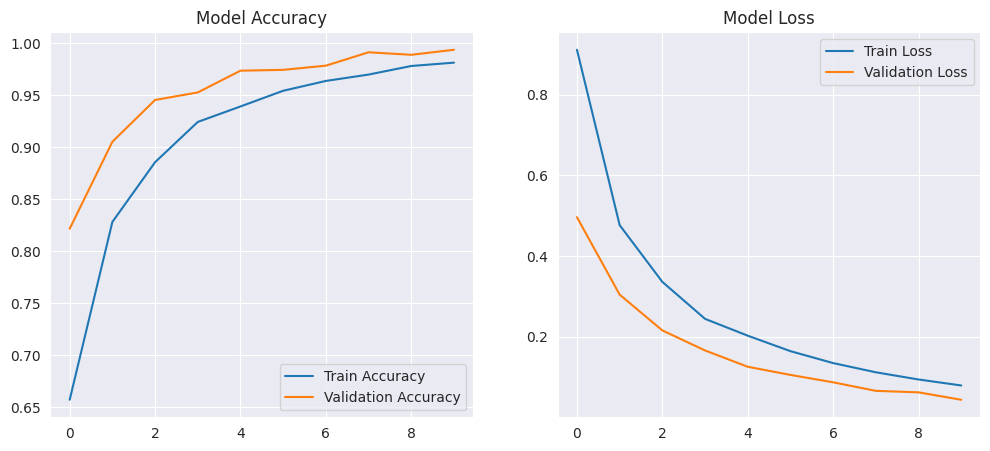

In [ ]:
# Train the model
history = resnet50_model.fit(train_gen, epochs=10, validation_data=valid_gen)

# Plot accuracy and loss curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import classification_report

y_pred = np.argmax(resnet50_model.predict(test_gen), axis=-1)
y_true = test_gen.classes

print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))

39/39 ━━━━━━━━━━━━━━━━━━━━ 18s 329ms/step
              precision    recall  f1-score   support

        Cyst       0.99      1.00      0.99       371
      Normal       0.99      1.00      1.00       508
       Stone       0.99      0.97      0.98       138
       Tumor       0.99      0.99      0.99       228

    accuracy                           0.99      1245
   macro avg       0.99      0.99      0.99      1245
weighted avg       0.99      0.99      0.99      1245



In [ ]:
# Save the model to a file
resnet50_model.save('ResNet50_Model.keras')

# **Using VGG16 Model**

In [ ]:
from keras.applications import VGG16
from keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model

In [ ]:
from keras.applications import VGG16
from keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model

vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg16_base.trainable = False

inputs = Input(shape=(224, 224, 3))

x = vgg16_base(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)
vgg16_model = Model(inputs, outputs)

vgg16_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
history3 = vgg16_model.fit(train_gen, epochs=50, validation_data=valid_gen)

Epoch 1/5


KeyboardInterrupt: 

NameError: name 'history3' is not defined

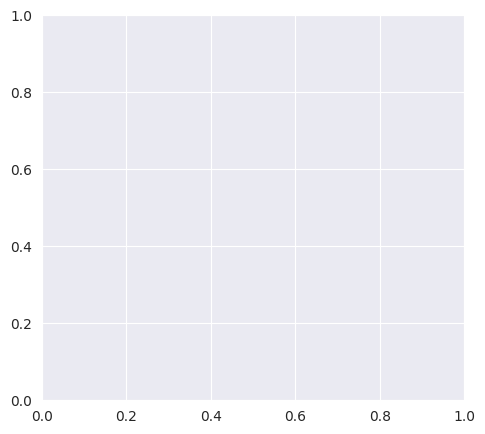

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'], label='Train Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'], label='Train Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import classification_report

y_pred = np.argmax(vgg16_model.predict(test_gen), axis=-1)
y_true = test_gen.classes

print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))

39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 249ms/step
              precision    recall  f1-score   support

        Cyst       0.99      1.00      1.00       371
      Normal       1.00      1.00      1.00       508
       Stone       1.00      0.98      0.99       138
       Tumor       1.00      1.00      1.00       228

    accuracy                           1.00      1245
   macro avg       1.00      0.99      1.00      1245
weighted avg       1.00      1.00      1.00      1245



In [ ]:
vgg16_model.save('VGG16_Model.keras')

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

model = tf.keras.models.load_model("kidney_model.keras")

# Define class labels
class_labels = ['Cyst', 'Normal', 'Stone', 'Tumor']

def classify_image(image_path):
    # Preprocess the image
    image = load_img(image_path, target_size=(224, 224))
    image_array = img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0)
    image_array = preprocess_input(image_array)
    # Predict the class
    predictions = model.predict(image_array)
    predicted_class = class_labels[np.argmax(predictions)]
    confidence = np.max(predictions)
    return predicted_class, confidence

from google.colab import files
uploaded = files.upload()

for filename in uploaded.keys():
    predicted_class, confidence = classify_image(filename)
    print(f"For {filename}, predicted class: {predicted_class}")
    print(f"Confidence: {confidence}")

In [ ]:
!pip install shap
!pip install shapash
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 14.1 MB/s eta 0:00:00


  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:44, 44.00s/it]               


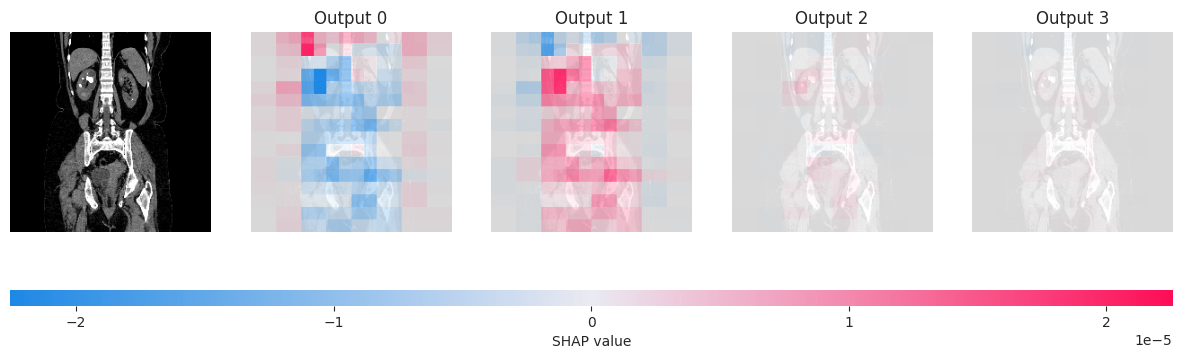

In [ ]:
import os
import numpy as np
import tensorflow as tf
import shap
from tensorflow.keras.models import load_model

dataset_dir = "/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"

image_path = "/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone/Stone- (113).jpg"

def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    return image.numpy()

image = preprocess_image(image_path)

model = load_model('/content/kidney_model.keras')

# /content/resnet50_kidney_classification_model.h5
# /content/resnet50_kidney_classification_model.keras
# /content/model.h5
def f(x):
    tmp = x.copy()
    return model(tmp)

masker_blur = shap.maskers.Image("blur(224,224)", shape=(224, 224, 3))

explainer_blur = shap.Explainer(f, masker_blur)

shap_values_fine = explainer_blur(image[np.newaxis, :, :, :], max_evals=5000, outputs=shap.Explanation.argsort.flip[:4])

shap.image_plot(shap_values_fine)

In [ ]:
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.3/26.3 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.8/538.8 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [ ]:
!pip install cloudpickle

In [ ]:
import mlflow
import mlflow.keras
import mlflow.tensorflow
from mlflow.models.signature import infer_signature
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
import numpy as np

In [ ]:
# Load the VGG16 model
vgg16_model_path = "/content/kidney_model (2).keras"
vgg16_model = tf.keras.models.load_model(vgg16_model_path)

# Prepare an example input for signature
example_input = load_img('/content/Tumor- (1016).jpg', target_size=(224, 224))  # Replace with your own sample image
example_input = img_to_array(example_input)
example_input = np.expand_dims(example_input, axis=0)
example_input = preprocess_input(example_input)

# Infer signature
signature = infer_signature(example_input)

# Log the VGG16 model with the signature
with mlflow.start_run(run_name="VGG16 Model"):
    mlflow.keras.log_model(vgg16_model, "vgg16_model", signature=signature)
    mlflow.log_metric("val_accuracy", 0.9944)  # Replace with actual value
    mlflow.log_metric("val_loss", 0.0239)      # Replace with actual value


NameError: name 'preprocess_input' is not defined

In [ ]:
# Load the CNN model
cnn_model_path = "/content/model.keras"
cnn_model = tf.keras.models.load_model(cnn_model_path)

# Infer signature (same process as above)
signature = infer_signature(example_input)

# Log the CNN model with the signature
with mlflow.start_run(run_name="CNN Model"):
    mlflow.keras.log_model(cnn_model, "cnn_model", signature=signature)
    mlflow.log_metric("val_accuracy", 0.965)   # Replace with actual value
    mlflow.log_metric("val_loss", 0.082)       # Replace with actual value


In [ ]:
# Load the ResNet50 model
resnet50_model_path = "/content/resnet50_kidney_classification_model.keras"
resnet50_model = tf.keras.models.load_model(resnet50_model_path)

# Infer signature (same process as above)
signature = infer_signature(example_input)

# Log the ResNet50 model with the signature
with mlflow.start_run(run_name="ResNet50 Model"):
    mlflow.keras.log_model(resnet50_model, "resnet50_model", signature=signature)
    mlflow.log_metric("val_accuracy", 0.980)   # Replace with actual value
    mlflow.log_metric("val_loss", 0.050)       # Replace with actual value


In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess


In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess

# Load the VGG16 model
vgg16_model_path = "/content/kidney_model (2).keras"
vgg16_model = tf.keras.models.load_model(vgg16_model_path)

# Prepare an example input for signature
example_input = load_img('/content/Tumor- (1016).jpg', target_size=(224, 224))  # Replace with your own sample image
example_input = img_to_array(example_input)
example_input = np.expand_dims(example_input, axis=0)
example_input = vgg16_preprocess(example_input)  # Using VGG16 preprocessing

# Infer signature
signature = infer_signature(example_input)

# Log the VGG16 model with the signature
with mlflow.start_run(run_name="VGG16 Model"):
    mlflow.keras.log_model(vgg16_model, "vgg16_model", signature=signature)
    mlflow.log_metric("val_accuracy", 0.9944)  # Replace with actual value
    mlflow.log_metric("val_loss", 0.0239)      # Replace with actual value


In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess

# Load the ResNet50 model
resnet50_model_path = "/content/resnet50_kidney_classification_model.keras"
resnet50_model = tf.keras.models.load_model(resnet50_model_path)

# Prepare an example input for signature
example_input = load_img('/content/Tumor- (1016).jpg', target_size=(224, 224))  # Replace with your own sample image
example_input = img_to_array(example_input)
example_input = np.expand_dims(example_input, axis=0)
example_input = resnet50_preprocess(example_input)  # Using ResNet50 preprocessing

# Infer signature
signature = infer_signature(example_input)

# Log the ResNet50 model with the signature
with mlflow.start_run(run_name="ResNet50 Model"):
    mlflow.keras.log_model(resnet50_model, "resnet50_model", signature=signature)
    mlflow.log_metric("val_accuracy", 0.980)   # Replace with actual value
    mlflow.log_metric("val_loss", 0.050)       # Replace with actual value


In [ ]:
# Display the logged runs
!mlflow ui


[2024-08-16 09:21:41 +0000] [5754] [INFO] Starting gunicorn 22.0.0
[2024-08-16 09:21:41 +0000] [5754] [INFO] Listening at: http://127.0.0.1:5000 (5754)
[2024-08-16 09:21:41 +0000] [5754] [INFO] Using worker: sync
[2024-08-16 09:21:41 +0000] [5759] [INFO] Booting worker with pid: 5759
[2024-08-16 09:21:41 +0000] [5760] [INFO] Booting worker with pid: 5760
[2024-08-16 09:21:41 +0000] [5761] [INFO] Booting worker with pid: 5761
[2024-08-16 09:21:41 +0000] [5762] [INFO] Booting worker with pid: 5762
[2024-08-16 09:27:08 +0000] [5754] [INFO] Handling signal: int
[2024-08-16 09:27:09 +0000] [5759] [INFO] Worker exiting (pid: 5759)
[2024-08-16 09:27:09 +0000] [5760] [INFO] Worker exiting (pid: 5760)
[2024-08-16 09:27:09 +0000] [5762] [INFO] Worker exiting (pid: 5762)
[2024-08-16 09:27:09 +0000] [5761] [INFO] Worker exiting (pid: 5761)

Aborted!
[2024-08-16 09:27:10 +0000] [5754] [INFO] Shutting down: Master


In [ ]:
import os

# Create a directory for MLflow experiments
mlflow_directory = "/content/mlruns"
if not os.path.exists(mlflow_directory):
    os.makedirs(mlflow_directory)


In [ ]:
import mlflow

# Set the tracking URI to the local path
mlflow.set_tracking_uri(f"file://{mlflow_directory}")


In [ ]:
!mlflow ui --backend-store-uri file:///path/to/mlruns


[2024-08-16 09:34:46 +0000] [8939] [INFO] Starting gunicorn 22.0.0
[2024-08-16 09:34:46 +0000] [8939] [INFO] Listening at: http://127.0.0.1:5000 (8939)
[2024-08-16 09:34:46 +0000] [8939] [INFO] Using worker: sync
[2024-08-16 09:34:46 +0000] [8940] [INFO] Booting worker with pid: 8940
[2024-08-16 09:34:46 +0000] [8941] [INFO] Booting worker with pid: 8941
[2024-08-16 09:34:46 +0000] [8942] [INFO] Booting worker with pid: 8942
[2024-08-16 09:34:46 +0000] [8943] [INFO] Booting worker with pid: 8943
[2024-08-16 09:40:13 +0000] [8939] [INFO] Handling signal: int

Aborted!
[2024-08-16 09:40:13 +0000] [8941] [INFO] Worker exiting (pid: 8941)
[2024-08-16 09:40:13 +0000] [8943] [INFO] Worker exiting (pid: 8943)
[2024-08-16 09:40:13 +0000] [8942] [INFO] Worker exiting (pid: 8942)
[2024-08-16 09:40:13 +0000] [8940] [INFO] Worker exiting (pid: 8940)
[2024-08-16 09:40:15 +0000] [8939] [INFO] Shutting down: Master
